In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
import seaborn as sns    
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU

#np.set_printoptions(threshold=np.inf)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/predicting_bitcoin_market

/content/gdrive/MyDrive/Colab Notebooks/predicting_bitcoin_market


In [4]:
org_df = pd.read_csv('crypto_data_news_reddit_final_05_26_v3.csv',index_col=0)

In [5]:
org_df

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,gnews_tb_polarity,gnews_tb_subjectivity,gnews_sid_pos,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 0:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23000,728.77,625.293831,0.042570,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01 1:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36000,724.27,710.891607,0.042570,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325
2018-01-01 2:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55000,722.11,849.257651,0.042570,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133
2018-01-01 3:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81000,733.19,556.397003,0.042570,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143
2018-01-01 4:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39000,738.59,1247.722800,0.042570,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-07 20:00,56153.84,56250.00,55717.15,56249.99,1716.413018,220.42,48764.98025,1988.38,26090.037240,0.253793,0.029387,0.113559,0.026367,0.005233,0.968433,0.258370,-0.582060,0.054772,0.214216,0.056400,0.034200,0.909400,0.043170
2021-04-07 21:00,56250.00,56374.25,56071.99,56205.73,1261.306956,220.50,43813.25247,1997.20,15115.859440,0.253793,0.029387,0.113559,0.026367,0.005233,0.968433,0.258370,-0.994800,0.117972,0.564390,0.132500,0.062500,0.804500,0.453300
2021-04-07 22:00,56205.73,56560.29,56108.60,56452.88,1353.731444,223.89,23235.14136,2007.28,18363.352850,0.253793,0.029387,0.113559,0.026367,0.005233,0.968433,0.258370,-0.876280,0.059048,0.233810,0.003600,0.079400,0.917000,-0.274480


In [6]:
org_df.columns

Index(['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT',
       'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD',
       'volume_ETHUSD', 'gnews_flair', 'gnews_tb_polarity',
       'gnews_tb_subjectivity', 'gnews_sid_pos', 'gnews_sid_neg',
       'gnews_sid_neu', 'gnews_sid_com', 'reddit_flair', 'reddit_tb_polarity',
       'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg',
       'reddit_sid_neu', 'reddit_sid_com'],
      dtype='object')

In [7]:
org_df['flair'] = org_df['gnews_flair'] + org_df['reddit_flair']
org_df['tb_polarity'] = org_df['gnews_tb_polarity'] + org_df['reddit_tb_polarity']
org_df['tb_subjectivity'] = org_df['gnews_tb_subjectivity'] + org_df['reddit_tb_subjectivity']
org_df['sid_pos'] = org_df['gnews_sid_pos'] + org_df['reddit_sid_pos']
org_df['sid_neg'] = org_df['gnews_sid_neg'] + org_df['reddit_sid_neg']
org_df = org_df[['open_BTCUSDT','high_BTCUSDT','low_BTCUSDT', 'close_BTCUSDT', 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'flair', 'tb_polarity', 'tb_subjectivity', 'sid_pos', 'sid_neg']]

In [9]:
org_df.corr()

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,flair,tb_polarity,tb_subjectivity,sid_pos,sid_neg
open_BTCUSDT,1.000000,0.999949,0.999927,0.999906,0.337097,0.608124,0.501350,0.883971,0.372526,-0.175567,-0.103424,-0.285244,-0.200217,-0.174330
high_BTCUSDT,0.999949,1.000000,0.999891,0.999951,0.339574,0.608874,0.503087,0.884382,0.374418,-0.175610,-0.103375,-0.284894,-0.200003,-0.173947
low_BTCUSDT,0.999927,0.999891,1.000000,0.999938,0.333493,0.607367,0.498012,0.883587,0.368802,-0.175477,-0.103445,-0.285725,-0.200471,-0.174774
close_BTCUSDT,0.999906,0.999951,0.999938,1.000000,0.336944,0.608203,0.500810,0.884024,0.371888,-0.175592,-0.103376,-0.285302,-0.200181,-0.174389
volume_BTCUSDT,0.337097,0.339574,0.333493,0.336944,1.000000,-0.019940,0.761399,0.207033,0.870084,-0.295443,-0.129516,-0.336335,-0.249501,-0.162049
close_LTCUSD,0.608124,0.608874,0.607367,0.608203,-0.019940,1.000000,0.150712,0.832511,0.018031,0.064179,0.009280,0.033646,0.045121,0.019128
volume_LTCUSD,0.501350,0.503087,0.498012,0.500810,0.761399,0.150712,1.000000,0.371248,0.804530,-0.261696,-0.111423,-0.290598,-0.216588,-0.160770
close_ETHUSD,0.883971,0.884382,0.883587,0.884024,0.207033,0.832511,0.371248,1.000000,0.256261,-0.078383,-0.067113,-0.173241,-0.125097,-0.091599
volume_ETHUSD,0.372526,0.374418,0.368802,0.371888,0.870084,0.018031,0.804530,0.256261,1.000000,-0.283430,-0.122105,-0.321927,-0.237720,-0.161043
flair,-0.175567,-0.175610,-0.175477,-0.175592,-0.295443,0.064179,-0.261696,-0.078383,-0.283430,1.000000,0.206527,0.250672,0.268002,0.029676


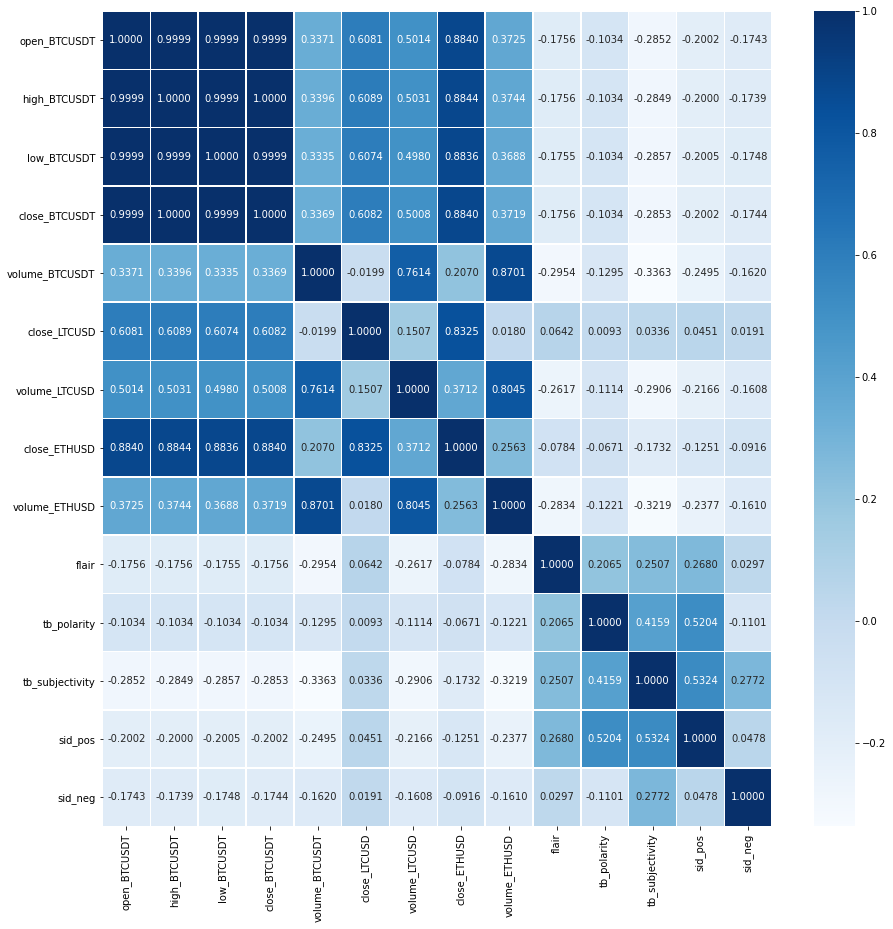

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(data = org_df.corr(), annot=True, 
fmt = '.4f', linewidths=.5, cmap='Blues')

In [ ]:
org_df

In [ ]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 14


In [ ]:
expr_name = 'expr_14'
look_back = 24*120 # 60 days, as each entry is for 1 hour
lstm_layers = 64
epochs=5
batch_size=64

In [ ]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('close_BTCUSDT')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  22906
Testing dataset length  5727
look_back  2880


In [ ]:
# create and fit the LSTM network

model = Sequential()
model.add(GRU(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
220/220 [==============================] - 49s 136ms/step - loss: 9.9218e-04 - val_loss: 9.8366e-04
Epoch 2/5
220/220 [==============================] - 29s 132ms/step - loss: 2.8217e-04 - val_loss: 0.0014
Epoch 3/5
220/220 [==============================] - 29s 132ms/step - loss: 2.9279e-04 - val_loss: 0.0015
Epoch 4/5
220/220 [==============================] - 29s 132ms/step - loss: 2.5041e-04 - val_loss: 0.0020
Epoch 5/5
220/220 [==============================] - 29s 132ms/step - loss: 1.7676e-04 - val_loss: 7.7362e-04


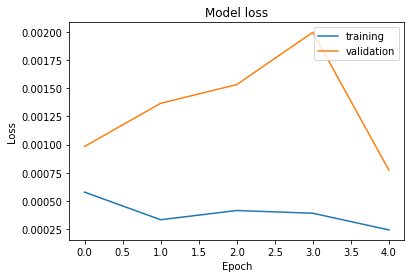

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

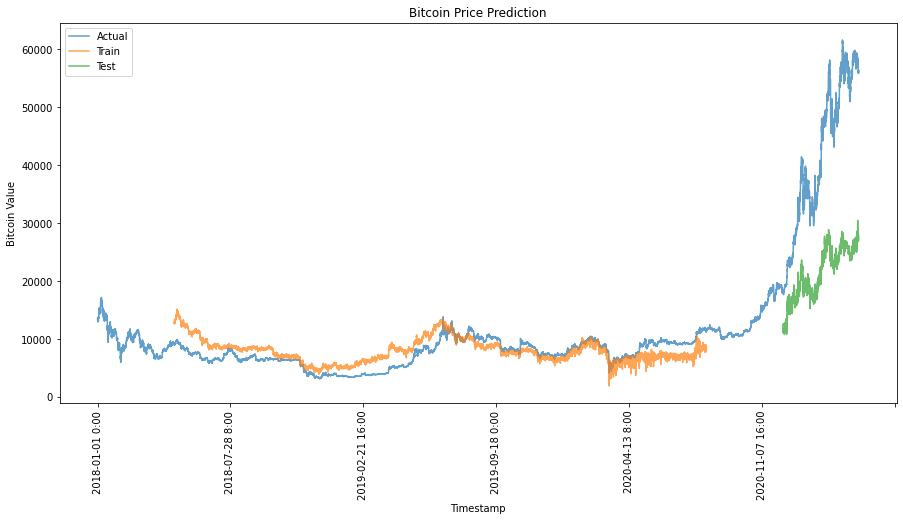

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [ ]:

print(df2)

               Test
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
...             ...
28628  26888.007812
28629  27440.822266
28630  27553.613281
28631  27682.816406
28632           NaN

[28633 rows x 1 columns]


In [ ]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_14
--------------------------------------------------
look_back days: 120.0
lstm_layers: 64
epochs: 5
batch_size: 64
dataset features ['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT', 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'flair', 'tb_polarity', 'tb_subjectivity', 'sid_pos', 'sid_neg']
--------------------------------------------------
Train Score: 1531.85 RMSE
Test Score: 19523.51 RMSE
--------------------------------------------------
Train Score: 1376.53 MAE
Test Score: 18288.49 MAE
--------------------------------------------------
Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                15360     
_________________________________________________________________
dense (Dense)            